# 사진 준비하기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

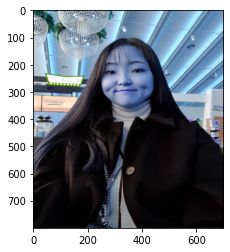

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/j_h.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옴
img_bgr = cv2.resize(img_bgr, (700, 800))
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)

plt.show()

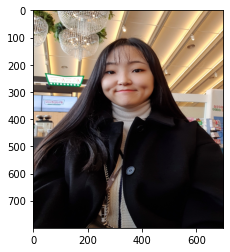

In [3]:
# RGB 이미지로 변경 후 plt.imshow 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출 face detection

In [4]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)  # 찾은 얼굴 영역 박스 리스트

rectangles[[(242, 160) (428, 345)]]


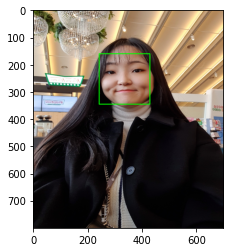

In [5]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 랜드마크 face landmark

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장함
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


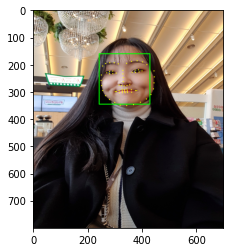

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용하기

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[0][0]  # 코의 index =  40  45
    y = landmark[23][1]
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (250,188)
(w,h) : (187,187)


In [10]:
sticker_path = os.getenv('HOME')+\
'/aiffel/camera_sticker/images/whisker.png' # 스티커 이미지 경로
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))  # 스티커 크기 줄임
print (img_sticker.shape)

(187, 187, 3)


(187, 187, 3)


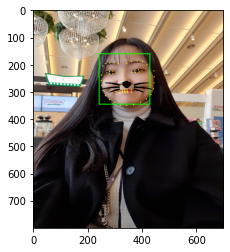

In [11]:
#  원본 이미지에 스티커를 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
print(sticker_area.shape)
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

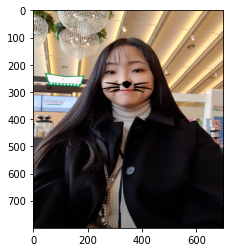

In [12]:
# 스티커만 출력
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 분석
### 1.얼굴 각도에 따라 스티커가 어떻게 변해야할까?
고개가 틀어진 방향으로 스티커 이미지를 회전시켜야 얼굴에 자연스럽게 스티커가 적용되어야 할 것이다.  
cv2.getRotationMatrix2D() 등의 메서드로 스티커를 회전시켜 적용하면 된다.

### 2.멀리서 촬영하면 왜 안될까? 옆으로 누워서 촬영하면 왜 안될까?
얼굴의 위치를 찾기 위해 gradient를 사용한다.  
gradient를 추출한 얼굴 형태와 기존에 학습한 얼굴의 grdient 형태를 비교해 가장 유사한 부분을 선택하기 때문에,  
멀리서 촬영하거나 옆으로 누워서 촬영하면 기존의 학습한 형태의 얼굴과 달라 얼굴의 위치를 인식하기 어렵다.  
또한 랜드마크의 좌표값을 통해 위치를 지정한 값이 정면을 보는 얼굴과 달라서 스티커 위치가 제대로 잡히지 않는다.

### 3. 실행 속도가 중요할까?
스노우와 같은 카메라 어플을 사용해보면 실행 속도가 매우 중요하다는 것을 알 수 있다.  
스티커를 변경할 때마다 얼굴을 바로 인식해서 적용되어야 하기 때문이다.  
이용자들은 이런 빠른 반응도 카메라 어플의 사용 이유중 하나일 것이다.

### 4. 스티커앱을 만들 때 정확도가 얼마나 중요할까?
실행속도뿐만 아니라 정확도도 매우 중요하다.  
얼굴을 인식 못하고 스티커를 엉뚱한 위치에 적용되면 이 스티커앱은 사용되지 않을 것이다.  
얼굴을 정확하게 인식하고 스티커를 적용해야 하므로 얼굴을 인식하기 위해 정확도는 필수이다. 

# 회고
처음에 사진을 가져오고 얼굴에 라벨링이 되지 않아 해결하는데 시간이 오래 걸렸었다.  
여러 사진을 가져와서 라벨링을 시도해보다가 이미지의 비율을 맞추자 라벨링이 되면서 이미지의 사이즈를 변환하는 과정에서 원본 비율을 맞춰야 라벨링이 가능하다는 것을 알게 되었다.  

그리고 코 위치에 고양이 수염을 딱 맞추기가 어려웠다. 인덱스를 조절하다가 고양이 수염을 반으로 줄여서 실행시켰더니 코에 맞출 수 있었다.   
그래서 스티커를 작게 만들고 인덱스를 옮기면서 위치 찾는 방법을 익히고 다시 스티커 원래 크기로 키워서 코에 인덱스를 맞출 수 있었다.  

얼굴각도, 밝기, 다수와 함께 있는 사진으로 dlib을 통한 face detection이 정상적으로 진행될 수 있을지 추가로 분석해보면 좋을 것 같다.